<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/017_TF_2_examples_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!cp /content/drive/MyDrive/dataset/synthetic_dataset.zip /content/

In [ ]:
!unzip /content/synthetic_dataset.zip

In [1]:
import cv2
import numpy as np
import tensorflow as tf

grid_h = 45
grid_w = 60

# # original paper anchors
# wandhG = np.array([[100.0, 100.0], [300.0, 300.0], [500.0, 500.0],
                   # [200.0, 100.0], [370.0, 185.0], [440.0, 220.0],
                   # [100.0, 200.0], [185.0, 370.0], [220.0, 440.0]])

# k-means anchors (recommend)
wandhG = np.array([[ 74., 149.],
                   [ 34., 149.],
                   [ 86.,  74.],
                   [109., 132.],
                   [172., 183.],
                   [103., 229.],
                   [149.,  91.],
                   [ 51., 132.],
                   [ 57., 200.]], dtype=np.float32)

def compute_iou(boxes1, boxes2):
    """(xmin, ymin, xmax, ymax)
    boxes1 shape:  [-1, 4], boxes2 shape: [-1, 4]
    """
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2], )
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])
    inter_wh = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = boxes1_area + boxes2_area - inter_area
    ious = inter_area / union_area
    return ious

def plot_boxes_on_image(show_image_with_boxes, boxes, color=[0, 0, 255], thickness=2):
    for box in boxes:
        cv2.rectangle(show_image_with_boxes,
                pt1=(int(box[0]), int(box[1])),
                pt2=(int(box[2]), int(box[3])), color=color, thickness=thickness)
    show_image_with_boxes = cv2.cvtColor(show_image_with_boxes, cv2.COLOR_BGR2RGB)
    return show_image_with_boxes

def load_gt_boxes(path):
    """
    Don't care about what shit it is. whatever, this function
    returns many ground truth boxes with the shape of [-1, 4].
    xmin, ymin, xmax, ymax
    """
    bbs = open(path).readlines()[1:]
    roi = np.zeros([len(bbs), 4])
    for iter_, bb in zip(range(len(bbs)), bbs):
        bb = bb.replace('\n', '').split(' ')
        bbtype = bb[0]
        bba = np.array([float(bb[i]) for i in range(1, 5)])
        # occ = float(bb[5])
        # bbv = np.array([float(bb[i]) for i in range(6, 10)])
        ignore = int(bb[10])

        ignore = ignore or (bbtype != 'person')
        ignore = ignore or (bba[3] < 40)
        bba[2] += bba[0]
        bba[3] += bba[1]

        roi[iter_, :4] = bba
    return roi

def compute_regression(box1, box2):
    """
    box1: ground-truth boxes
    box2: anchor boxes
    """
    target_reg = np.zeros(shape=[4,])
    w1 = box1[2] - box1[0]
    h1 = box1[3] - box1[1]
    w2 = box2[2] - box2[0]
    h2 = box2[3] - box2[1]

    target_reg[0] = (box1[0] - box2[0]) / w2
    target_reg[1] = (box1[1] - box2[1]) / h2
    target_reg[2] = np.log(w1 / w2)
    target_reg[3] = np.log(h1 / h2)

    return target_reg

def decode_output(pred_bboxes, pred_scores, score_thresh=0.5):
    """
    pred_bboxes shape: [1, 45, 60, 9, 4]
    pred_scores shape: [1, 45, 60, 9, 2]
    """
    grid_x, grid_y = tf.range(60, dtype=tf.int32), tf.range(45, dtype=tf.int32)
    grid_x, grid_y = tf.meshgrid(grid_x, grid_y)
    grid_x, grid_y = tf.expand_dims(grid_x, -1), tf.expand_dims(grid_y, -1)
    grid_xy = tf.stack([grid_x, grid_y], axis=-1)
    center_xy = grid_xy * 16 + 8
    center_xy = tf.cast(center_xy, tf.float32)
    anchor_xymin = center_xy - 0.5 * wandhG

    xy_min = pred_bboxes[..., 0:2] * wandhG[:, 0:2] + anchor_xymin
    xy_max = tf.exp(pred_bboxes[..., 2:4]) * wandhG[:, 0:2] + xy_min

    pred_bboxes = tf.concat([xy_min, xy_max], axis=-1)
    pred_scores = pred_scores[..., 1]
    score_mask = pred_scores > score_thresh
    pred_bboxes = tf.reshape(pred_bboxes[score_mask], shape=[-1,4]).numpy()
    pred_scores = tf.reshape(pred_scores[score_mask], shape=[-1,]).numpy()
    return  pred_scores, pred_bboxes


def nms(pred_boxes, pred_score, iou_thresh):
    """
    pred_boxes shape: [-1, 4]
    pred_score shape: [-1,]
    """
    selected_boxes = []
    while len(pred_boxes) > 0:
        max_idx = np.argmax(pred_score)
        selected_box = pred_boxes[max_idx]
        selected_boxes.append(selected_box)
        pred_boxes = np.concatenate([pred_boxes[:max_idx], pred_boxes[max_idx+1:]])
        pred_score = np.concatenate([pred_score[:max_idx], pred_score[max_idx+1:]])
        ious = compute_iou(selected_box, pred_boxes)
        iou_mask = ious <= 0.1
        pred_boxes = pred_boxes[iou_mask]
        pred_score = pred_score[iou_mask]

    selected_boxes = np.array(selected_boxes)
    return selected_boxes

In [2]:
#demo
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
#from utils import compute_iou, plot_boxes_on_image, wandhG, load_gt_boxes, compute_regression, decode_output

pos_thresh = 0.5
neg_thresh = 0.1
iou_thresh = 0.5
grid_width = 16
grid_height = 16
image_height = 720
image_width = 960

image_path = "/content/synthetic_dataset/image/1.jpg"
label_path = "/content/synthetic_dataset/imageAno/1.txt"
gt_boxes = load_gt_boxes(label_path)
raw_image = cv2.imread(image_path)
image_with_gt_boxes = np.copy(raw_image)
plot_boxes_on_image(image_with_gt_boxes, gt_boxes)
Image.fromarray(image_with_gt_boxes).show()
encoded_image = np.copy(raw_image)

target_scores = np.zeros(shape=[45, 60, 9, 2]) # 0: background, 1: foreground, ,
target_bboxes = np.zeros(shape=[45, 60, 9, 4]) # t_x, t_y, t_w, t_h
target_masks  = np.zeros(shape=[45, 60, 9]) # negative_samples: -1, positive_samples: 1





In [3]:
################################### DECODE OUTPUT #################################

decode_image = np.copy(raw_image)
pred_boxes = []
pred_score = []

for i in range(45):
    for j in range(60):
        for k in range(9):
            # pred boxes coordinate
            center_x = j * grid_width + 0.5 * grid_width
            center_y = i * grid_height + 0.5 * grid_height
            anchor_xmin = center_x - 0.5 * wandhG[k, 0]
            anchor_ymin = center_y - 0.5 * wandhG[k, 1]

            xmin = target_bboxes[i, j, k, 0] * wandhG[k, 0] + anchor_xmin
            ymin = target_bboxes[i, j, k, 1] * wandhG[k, 1] + anchor_ymin
            xmax = tf.exp(target_bboxes[i, j, k, 2]) * wandhG[k, 0] + xmin
            ymax = tf.exp(target_bboxes[i, j, k, 3]) * wandhG[k, 1] + ymin

            if target_scores[i, j, k, 1] > 0: # it is a positive sample
                print("=> Decoding positive sample: %d, %d, %d" %(i, j, k))
                cv2.circle(decode_image, center=(int(0.5*(xmin+xmax)), int(0.5*(ymin+ymax))),
                                radius=1, color=[255,0,0], thickness=4)
                pred_boxes.append(np.array([xmin, ymin, xmax, ymax]))
                pred_score.append(target_scores[i, j, k, 1])

pred_boxes = np.array(pred_boxes)
plot_boxes_on_image(decode_image, pred_boxes, color=[0, 255, 0])
Image.fromarray(np.uint8(decode_image)).show()




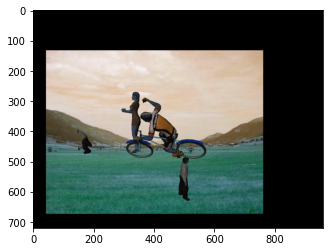

In [8]:
import matplotlib.pyplot as plt
plt.imshow(raw_image)

In [9]:
################################### ENCODE INPUT #################################

for i in range(45):
    for j in range(60):
        for k in range(9):
            center_x = j * grid_width + grid_width * 0.5
            center_y = i * grid_height + grid_height * 0.5
            xmin = center_x - wandhG[k][0] * 0.5
            ymin = center_y - wandhG[k][1] * 0.5
            xmax = center_x + wandhG[k][0] * 0.5
            ymax = center_y + wandhG[k][1] * 0.5
            # ignore cross-boundary anchors
            if (xmin > -5) & (ymin > -5) & (xmax < (image_width+5)) & (ymax < (image_height+5)):
                anchor_boxes = np.array([xmin, ymin, xmax, ymax])
                anchor_boxes = np.expand_dims(anchor_boxes, axis=0)
                # compute iou between this anchor and all ground-truth boxes in image.
                ious = compute_iou(anchor_boxes, gt_boxes)
                positive_masks = ious > pos_thresh
                negative_masks = ious < neg_thresh

                if np.any(positive_masks):
                    plot_boxes_on_image(encoded_image, anchor_boxes, thickness=1)
                    print("=> Encoding positive sample: %d, %d, %d" %(i, j, k))
                    cv2.circle(encoded_image, center=(int(0.5*(xmin+xmax)), int(0.5*(ymin+ymax))),
                                    radius=1, color=[255,0,0], thickness=4)

                    target_scores[i, j, k, 1] = 1.
                    target_masks[i, j, k] = 1 # labeled as a positive sample
                    # find out which ground-truth box matches this anchor
                    max_iou_idx = np.argmax(ious)
                    selected_gt_boxes = gt_boxes[max_iou_idx]
                    target_bboxes[i, j, k] = compute_regression(selected_gt_boxes, anchor_boxes[0])

                if np.all(negative_masks):
                    target_scores[i, j, k, 0] = 1.
                    target_masks[i, j, k] = -1 # labeled as a negative sample
                    cv2.circle(encoded_image, center=(int(0.5*(xmin+xmax)), int(0.5*(ymin+ymax))),
                                    radius=1, color=[0,0,0], thickness=4)

Image.fromarray(encoded_image).show()

=> Encoding positive sample: 20, 20, 0
=> Encoding positive sample: 20, 20, 7
=> Encoding positive sample: 20, 20, 8
=> Encoding positive sample: 21, 19, 0
=> Encoding positive sample: 21, 19, 8
=> Encoding positive sample: 21, 20, 0
=> Encoding positive sample: 21, 20, 7
=> Encoding positive sample: 21, 20, 8
=> Encoding positive sample: 21, 25, 4
=> Encoding positive sample: 21, 26, 4
=> Encoding positive sample: 22, 19, 0
=> Encoding positive sample: 22, 19, 8
=> Encoding positive sample: 22, 20, 0
=> Encoding positive sample: 22, 20, 7
=> Encoding positive sample: 22, 20, 8
=> Encoding positive sample: 22, 24, 4
=> Encoding positive sample: 22, 24, 5
=> Encoding positive sample: 22, 25, 4
=> Encoding positive sample: 22, 25, 5
=> Encoding positive sample: 22, 26, 4
=> Encoding positive sample: 22, 26, 5
=> Encoding positive sample: 22, 27, 4
=> Encoding positive sample: 22, 27, 5
=> Encoding positive sample: 23, 19, 0
=> Encoding positive sample: 23, 19, 8
=> Encoding positive samp

In [10]:
############################## FASTER DECODE OUTPUT ###############################

faster_decode_image = np.copy(raw_image)
pred_bboxes = np.expand_dims(target_bboxes, 0).astype(np.float32)
pred_scores = np.expand_dims(target_scores, 0).astype(np.float32)

pred_scores, pred_bboxes = decode_output(pred_bboxes, pred_scores)
plot_boxes_on_image(faster_decode_image, pred_bboxes, color=[255, 0, 0]) # red boundig box
Image.fromarray(np.uint8(faster_decode_image)).show()

k-means

In [35]:
import glob
import numpy as np
#from utils import load_gt_boxes

def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2)
    '''
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)
        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

def get_wh_from_boxes(boxes):
    """
    box shape: [-1, 4], return the width and height of boxes
    """
    return boxes[..., 2:4] - boxes[..., 0:2]

text_paths = glob.glob("./synthetic_dataset/imageAno/*.txt")
all_boxes = [load_gt_boxes(path) for path in text_paths]
all_boxes = np.vstack(all_boxes)
all_boxes_wh = get_wh_from_boxes(all_boxes)
anchors = kmeans(all_boxes_wh, k=9)
print(anchors)

[[109. 166.]
 [132.  80.]
 [ 97. 114.]
 [ 80. 235.]
 [177. 132.]
 [155. 229.]
 [ 63. 149.]
 [ 40. 155.]
 [ 68.  74.]]


model

In [36]:
import tensorflow as tf

class RPNplus(tf.keras.Model):
    # VGG_MEAN = [103.939, 116.779, 123.68]
    def __init__(self):
        super(RPNplus, self).__init__()
        # conv1
        self.conv1_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.conv1_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.pool1   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')

        # conv2
        self.conv2_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.conv2_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.pool2   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')

        # conv3
        self.conv3_1 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.pool3   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')

        # conv4
        self.conv4_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool4   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')

        # conv5
        self.conv5_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool5   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')

        ## region_proposal_conv
        self.region_proposal_conv1 = tf.keras.layers.Conv2D(256, kernel_size=[5,2],
                                                            activation=tf.nn.relu,
                                                            padding='same', use_bias=False)
        self.region_proposal_conv2 = tf.keras.layers.Conv2D(512, kernel_size=[5,2],
                                                            activation=tf.nn.relu,
                                                            padding='same', use_bias=False)
        self.region_proposal_conv3 = tf.keras.layers.Conv2D(512, kernel_size=[5,2],
                                                            activation=tf.nn.relu,
                                                            padding='same', use_bias=False)
        ## Bounding Boxes Regression layer
        self.bboxes_conv = tf.keras.layers.Conv2D(36, kernel_size=[1,1],
                                                padding='same', use_bias=False)
        ## Output Scores layer
        self.scores_conv = tf.keras.layers.Conv2D(18, kernel_size=[1,1],
                                                padding='same', use_bias=False)


    def call(self, x, training=False):
        h = self.conv1_1(x)
        h = self.conv1_2(h)
        h = self.pool1(h)

        h = self.conv2_1(h)
        h = self.conv2_2(h)
        h = self.pool2(h)

        h = self.conv3_1(h)
        h = self.conv3_2(h)
        h = self.conv3_3(h)
        h = self.pool3(h)
        # Pooling to same size
        pool3_p = tf.nn.max_pool2d(h, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='SAME', name='pool3_proposal')
        pool3_p = self.region_proposal_conv1(pool3_p) # [1, 45, 60, 256]

        h = self.conv4_1(h)
        h = self.conv4_2(h)
        h = self.conv4_3(h)
        h = self.pool4(h)
        pool4_p = self.region_proposal_conv2(h) # [1, 45, 60, 512]

        h = self.conv5_1(h)
        h = self.conv5_2(h)
        h = self.conv5_3(h)
        pool5_p = self.region_proposal_conv2(h) # [1, 45, 60, 512]

        region_proposal = tf.concat([pool3_p, pool4_p, pool5_p], axis=-1) # [1, 45, 60, 1280]

        conv_cls_scores = self.scores_conv(region_proposal) # [1, 45, 60, 18]
        conv_cls_bboxes = self.bboxes_conv(region_proposal) # [1, 45, 60, 36]

        cls_scores = tf.reshape(conv_cls_scores, [-1, 45, 60, 9, 2])
        cls_bboxes = tf.reshape(conv_cls_bboxes, [-1, 45, 60, 9, 4])

        return cls_scores, cls_bboxes

train

In [38]:
import os
import cv2
import random
import tensorflow as tf
import numpy as np
## from utils import compute_iou, load_gt_boxes, wandhG, compute_regression
## from rpn import RPNplus

pos_thresh = 0.5
neg_thresh = 0.1
grid_width = grid_height = 16
image_height, image_width = 720, 960

def encode_label(gt_boxes):
    target_scores = np.zeros(shape=[45, 60, 9, 2]) # 0: background, 1: foreground, ,
    target_bboxes = np.zeros(shape=[45, 60, 9, 4]) # t_x, t_y, t_w, t_h
    target_masks  = np.zeros(shape=[45, 60, 9]) # negative_samples: -1, positive_samples: 1
    for i in range(45): # y: height
        for j in range(60): # x: width
            for k in range(9):
                center_x = j * grid_width + grid_width * 0.5
                center_y = i * grid_height + grid_height * 0.5
                xmin = center_x - wandhG[k][0] * 0.5
                ymin = center_y - wandhG[k][1] * 0.5
                xmax = center_x + wandhG[k][0] * 0.5
                ymax = center_y + wandhG[k][1] * 0.5
                # print(xmin, ymin, xmax, ymax)
                # ignore cross-boundary anchors
                if (xmin > -5) & (ymin > -5) & (xmax < (image_width+5)) & (ymax < (image_height+5)):
                    anchor_boxes = np.array([xmin, ymin, xmax, ymax])
                    anchor_boxes = np.expand_dims(anchor_boxes, axis=0)
                    # compute iou between this anchor and all ground-truth boxes in image.
                    ious = compute_iou(anchor_boxes, gt_boxes)
                    positive_masks = ious >= pos_thresh
                    negative_masks = ious <= neg_thresh

                    if np.any(positive_masks):
                        target_scores[i, j, k, 1] = 1.
                        target_masks[i, j, k] = 1 # labeled as a positive sample
                        # find out which ground-truth box matches this anchor
                        max_iou_idx = np.argmax(ious)
                        selected_gt_boxes = gt_boxes[max_iou_idx]
                        target_bboxes[i, j, k] = compute_regression(selected_gt_boxes, anchor_boxes[0])

                    if np.all(negative_masks):
                        target_scores[i, j, k, 0] = 1.
                        target_masks[i, j, k] = -1 # labeled as a negative sample
    return target_scores, target_bboxes, target_masks

def process_image_label(image_path, label_path):
    raw_image = cv2.imread(image_path)
    gt_boxes = load_gt_boxes(label_path)
    target = encode_label(gt_boxes)
    return raw_image/255., target

def create_image_label_path_generator(synthetic_dataset_path):
    image_num = 8000
    image_label_paths = [(os.path.join(synthetic_dataset_path, "image/%d.jpg" %(idx+1)),
                          os.path.join(synthetic_dataset_path, "imageAno/%d.txt"%(idx+1))) for idx in range(image_num)]
    while True:
        random.shuffle(image_label_paths)
        for i in range(image_num):
            yield image_label_paths[i]

def DataGenerator(synthetic_dataset_path, batch_size):
    """
    generate image and mask at the same time
    """
    image_label_path_generator = create_image_label_path_generator(synthetic_dataset_path)
    while True:
        images = np.zeros(shape=[batch_size, image_height, image_width, 3], dtype=np.float)
        target_scores = np.zeros(shape=[batch_size, 45, 60, 9, 2], dtype=np.float)
        target_bboxes = np.zeros(shape=[batch_size, 45, 60, 9, 4], dtype=np.float)
        target_masks  = np.zeros(shape=[batch_size, 45, 60, 9], dtype=np.int)

        for i in range(batch_size):
            image_path, label_path = next(image_label_path_generator)
            image, target = process_image_label(image_path, label_path)
            images[i] = image
            target_scores[i] = target[0]
            target_bboxes[i] = target[1]
            target_masks[i]  = target[2]
        yield images, target_scores, target_bboxes, target_masks

def compute_loss(target_scores, target_bboxes, target_masks, pred_scores, pred_bboxes):
    """
    target_scores shape: [1, 45, 60, 9, 2],  pred_scores shape: [1, 45, 60, 9, 2]
    target_bboxes shape: [1, 45, 60, 9, 4],  pred_bboxes shape: [1, 45, 60, 9, 4]
    target_masks  shape: [1, 45, 60, 9]
    """
    score_loss = tf.nn.softmax_cross_entropy_with_logits(labels=target_scores, logits=pred_scores)
    foreground_background_mask = (np.abs(target_masks) == 1).astype(np.int)
    score_loss = tf.reduce_sum(score_loss * foreground_background_mask, axis=[1,2,3]) / np.sum(foreground_background_mask)
    score_loss = tf.reduce_mean(score_loss)

    boxes_loss = tf.abs(target_bboxes - pred_bboxes)
    boxes_loss = 0.5 * tf.pow(boxes_loss, 2) * tf.cast(boxes_loss<1, tf.float32) + (boxes_loss - 0.5) * tf.cast(boxes_loss >=1, tf.float32)
    boxes_loss = tf.reduce_sum(boxes_loss, axis=-1)
    foreground_mask = (target_masks > 0).astype(np.float32)
    boxes_loss = tf.reduce_sum(boxes_loss * foreground_mask, axis=[1,2,3]) / np.sum(foreground_mask)
    boxes_loss = tf.reduce_mean(boxes_loss)

    return score_loss, boxes_loss

EPOCHS = 10
STEPS = 4000
batch_size = 2
lambda_scale = 1.
synthetic_dataset_path="./synthetic_dataset"
TrainSet = DataGenerator(synthetic_dataset_path, batch_size)

model = RPNplus()
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
writer = tf.summary.create_file_writer("./log")
global_steps = tf.Variable(0, trainable=False, dtype=tf.int64)

for epoch in range(EPOCHS):
    for step in range(STEPS):
        global_steps.assign_add(1)
        image_data, target_scores, target_bboxes, target_masks = next(TrainSet)
        with tf.GradientTape() as tape:
            pred_scores, pred_bboxes = model(image_data)
            score_loss, boxes_loss = compute_loss(target_scores, target_bboxes, target_masks, pred_scores, pred_bboxes)
            total_loss = score_loss + lambda_scale * boxes_loss
            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            if step %50 == 0:
              print("=> epoch %d  step %d  total_loss: %.6f  score_loss: %.6f  boxes_loss: %.6f" %(epoch+1, step+1,
                                                          total_loss.numpy(), score_loss.numpy(), boxes_loss.numpy()))
        # writing summary data
        with writer.as_default():
            tf.summary.scalar("total_loss", total_loss, step=global_steps)
            tf.summary.scalar("score_loss", score_loss, step=global_steps)
            tf.summary.scalar("boxes_loss", boxes_loss, step=global_steps)
        writer.flush()
    model.save_weights("RPN.h5")

=> epoch 1  step 1  total_loss: 0.406488  score_loss: 0.346276  boxes_loss: 0.060212
=> epoch 1  step 51  total_loss: 0.071613  score_loss: 0.027209  boxes_loss: 0.044404
=> epoch 1  step 101  total_loss: 0.069568  score_loss: 0.020857  boxes_loss: 0.048711
=> epoch 1  step 151  total_loss: 0.067625  score_loss: 0.018688  boxes_loss: 0.048936
=> epoch 1  step 201  total_loss: 0.065886  score_loss: 0.015089  boxes_loss: 0.050797
=> epoch 1  step 251  total_loss: 0.049531  score_loss: 0.013025  boxes_loss: 0.036505
=> epoch 1  step 301  total_loss: 0.067522  score_loss: 0.015636  boxes_loss: 0.051886
=> epoch 1  step 351  total_loss: 0.037301  score_loss: 0.009602  boxes_loss: 0.027699
=> epoch 1  step 401  total_loss: 0.046352  score_loss: 0.012615  boxes_loss: 0.033737
=> epoch 1  step 451  total_loss: 0.062025  score_loss: 0.015271  boxes_loss: 0.046755
=> epoch 1  step 501  total_loss: 0.050478  score_loss: 0.008773  boxes_loss: 0.041705
=> epoch 1  step 551  total_loss: 0.041393  sc

KeyboardInterrupt: ignored

test

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
# from rpn import RPNplus
# from utils import decode_output, plot_boxes_on_image, nms

synthetic_dataset_path ="./synthetic_dataset"
prediction_result_path = "./prediction"
if not os.path.exists(prediction_result_path): os.mkdir(prediction_result_path)

model = RPNplus()
fake_data = np.ones(shape=[1, 720, 960, 3]).astype(np.float32)
model(fake_data) # initialize model to load weights
model.load_weights("./RPN.h5")

for idx in range(8000, 8200):
    image_path = os.path.join(synthetic_dataset_path, "image/%d.jpg" %(idx+1))
    raw_image = cv2.imread(image_path)
    image_data = np.expand_dims(raw_image / 255., 0)
    pred_scores, pred_bboxes = model(image_data)
    pred_scores = tf.nn.softmax(pred_scores, axis=-1)
    pred_scores, pred_bboxes = decode_output(pred_bboxes, pred_scores, 0.9)
    pred_bboxes = nms(pred_bboxes, pred_scores, 0.5)
    plot_boxes_on_image(raw_image, pred_bboxes)
    save_path = os.path.join(prediction_result_path, str(idx)+".jpg")
    print("=> saving prediction results into %s" %save_path)
    Image.fromarray(raw_image).save(save_path)

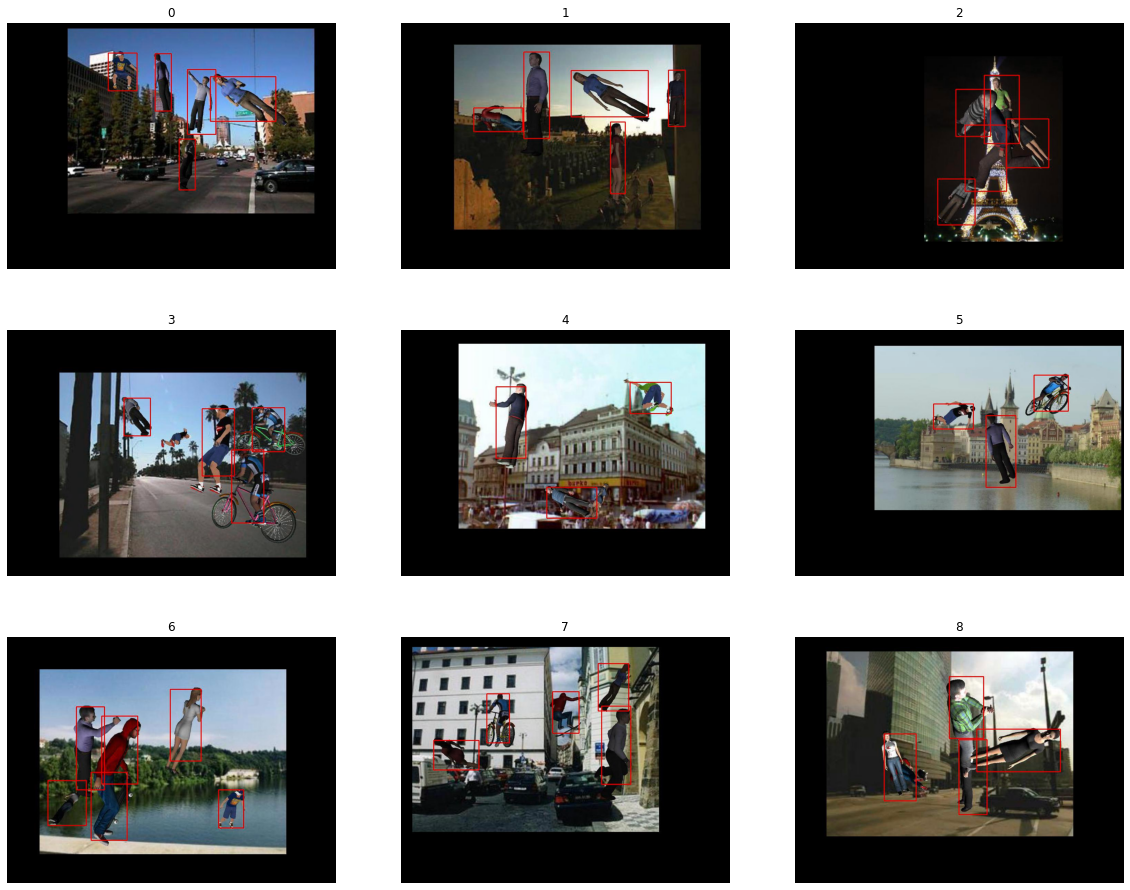

In [52]:
import os
import matplotlib.pyplot as plt
prediction_path = '/content/prediction/'
plt.figure(figsize = (20,16))
for i,filename in enumerate(os.listdir(prediction_path)):
  if i >= 9:
    break
  img = cv2.imread(prediction_path+filename)
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('%d'%i)